# 📈 Business Metrics & Customer Value Analysis

**هدف:** تحلیل متریک‌های بیزینسی، ارزش مشتری، و تحلیل‌های تکمیلی

## 📋 فهرست:

1. **Basic Business Metrics** - CSAT, Ticket Rates, Orders/Day
2. **Comment Analysis & Word Cloud** - تحلیل متنی کامنت‌ها
3. **Churn Rate Trend Over Time** - ترند چرن در گذر زمان
4. **Conversion & Retention Analysis** - تحلیل نگهداشت
5. **Customer Lifetime Analysis** - تحلیل چرخه عمر
6. **Customer Lifetime Value (CLV)** - ارزش طول عمر مشتری
7. **Delivery Performance Analysis** - تحلیل عملکرد تحویل

## 0️⃣ Setup & Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import jdatetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For word cloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print('WordCloud not installed. Run: pip install wordcloud')
    WORDCLOUD_AVAILABLE = False

# For Persian text processing
try:
    import hazm
    HAZM_AVAILABLE = True
except ImportError:
    print('Hazm not installed. Run: pip install hazm')
    HAZM_AVAILABLE = False

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Colors
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#28A745',
    'warning': '#F18F01',
    'danger': '#C73E1D',
    'info': '#17A2B8'
}

print('✅ Libraries loaded successfully!')

Hazm not installed. Run: pip install hazm
✅ Libraries loaded successfully!


In [3]:
# Helper functions for Jalali dates
def to_jalali(date):
    """Convert Gregorian date to Jalali string format."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return j_date.strftime('%Y/%m/%d')

def to_jalali_year_month(date):
    """Get Jalali year-month for grouping."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return f"{j_date.year}-{j_date.month:02d}"

def to_jalali_week(date):
    """Get Jalali year-week for grouping."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    week_num = (j_date.day - 1) // 7 + 1
    return f"{j_date.year}-{j_date.month:02d}-W{week_num}"

print('✅ Helper functions ready!')

✅ Helper functions ready!


## 1️⃣ Data Loading

In [4]:
# Load data
DATA_DIR = '../data'

orders_df = pd.read_csv(f'{DATA_DIR}/orders.csv')
crm_df = pd.read_csv(f'{DATA_DIR}/crm.csv')
comments_df = pd.read_csv(f'{DATA_DIR}/order_comments.csv')

# Convert dates
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# Merge orders with CRM
crm_cols = ['order_id', 'crm_delivery_request_count', 'crm_fake_delivery_request_count', 
            'rate_to_shop', 'rate_to_courier']
master_df = orders_df.merge(crm_df[crm_cols], on='order_id', how='left')

# Add time columns
master_df['order_month'] = master_df['order_date'].dt.to_period('M')
master_df['order_week'] = master_df['order_date'].dt.to_period('W')
master_df['order_day'] = master_df['order_date'].dt.date
master_df['order_month_jalali'] = master_df['order_date'].apply(to_jalali_year_month)

# Date range
min_date = master_df['order_date'].min()
max_date = master_df['order_date'].max()
date_range_days = (max_date - min_date).days

print('📁 Dataset Loaded:')
print(f'   Orders: {len(master_df):,}')
print(f'   Users:  {master_df["user_id"].nunique():,}')
print(f'   Date Range: {to_jalali(min_date)} to {to_jalali(max_date)} ({date_range_days} days)')

📁 Dataset Loaded:
   Orders: 2,720,059
   Users:  375,998
   Date Range: 1403/12/26 to 1404/06/21 (180 days)


## 2️⃣ Basic Business Metrics

متریک‌های اصلی کسب‌وکار:
- **CSAT**: میانگین امتیاز رضایت مشتری
- **Ticket Rate**: درصد سفارش‌هایی که تیکت داشتن
- **Fake Ticket Rate**: درصد تیکت‌های فیک از کل تیکت‌ها
- **Gross Orders/Day**: تعداد سفارشات روزانه
- **OTD Rate**: نرخ تحویل به موقع
- **Delivery Rate**: نرخ تحویل موفق

In [5]:
print('='*70)
print('📊 BASIC BUSINESS METRICS')
print('='*70)

# Total Orders
total_orders = len(master_df)
total_users = master_df['user_id'].nunique()

# Gross Orders Per Day
orders_per_day = master_df.groupby('order_day').size()
avg_orders_per_day = orders_per_day.mean()
median_orders_per_day = orders_per_day.median()
max_orders_per_day = orders_per_day.max()
min_orders_per_day = orders_per_day.min()

print(f'''
📦 ORDER VOLUME:
   Total Orders:       {total_orders:>12,}
   Total Users:        {total_users:>12,}
   Orders/User (avg):  {total_orders/total_users:>12.2f}
   
📅 DAILY ORDERS:
   Average/Day:        {avg_orders_per_day:>12,.0f}
   Median/Day:         {median_orders_per_day:>12,.0f}
   Max/Day:            {max_orders_per_day:>12,}
   Min/Day:            {min_orders_per_day:>12,}
''')

📊 BASIC BUSINESS METRICS

📦 ORDER VOLUME:
   Total Orders:          2,720,059
   Total Users:             375,998
   Orders/User (avg):          7.23
   
📅 DAILY ORDERS:
   Average/Day:              15,111
   Median/Day:               15,668
   Max/Day:                  23,427
   Min/Day:                   2,858



⭐ CSAT - Customer Satisfaction Score

🏪 SHOP RATING:
   Average Score:      4.42 / 5.00
   Total Ratings:      1,126,369 (41.4% of orders)
   
🚴 COURIER RATING:
   Average Score:      4.68 / 5.00
   Total Ratings:      714,590 (26.3% of orders)



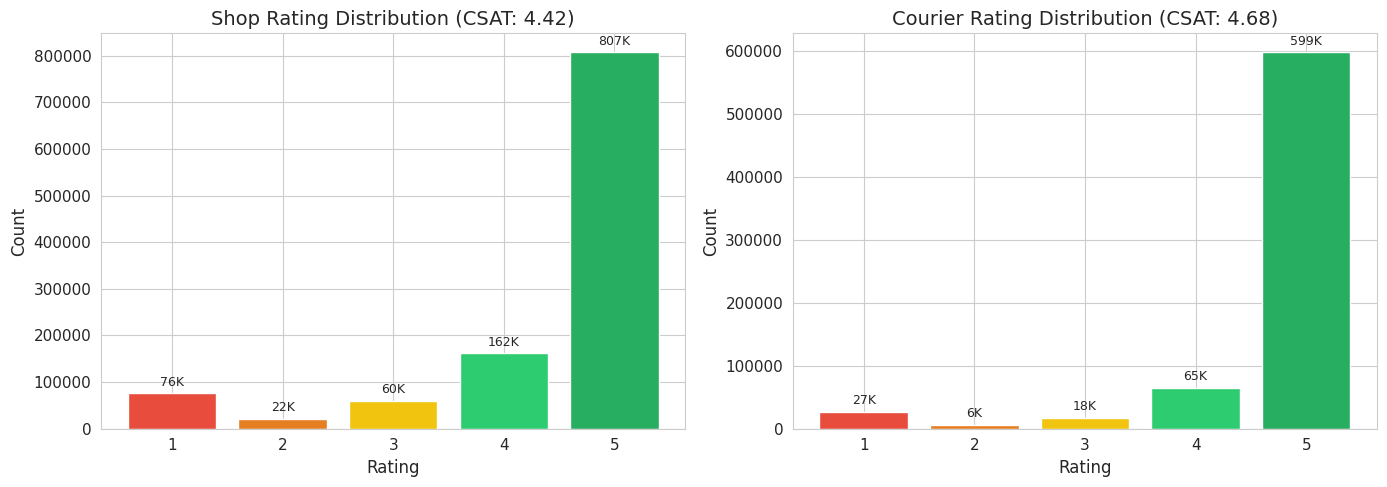

In [6]:
# CSAT - Customer Satisfaction Score
print('='*70)
print('⭐ CSAT - Customer Satisfaction Score')
print('='*70)

# Shop rating (rate_to_shop)
shop_ratings = master_df['rate_to_shop'].dropna()
shop_csat = shop_ratings.mean()
shop_rating_count = len(shop_ratings)
shop_rating_rate = shop_rating_count / total_orders * 100

# Courier rating (rate_to_courier)
courier_ratings = master_df['rate_to_courier'].dropna()
courier_csat = courier_ratings.mean()
courier_rating_count = len(courier_ratings)
courier_rating_rate = courier_rating_count / total_orders * 100

print(f'''
🏪 SHOP RATING:
   Average Score:      {shop_csat:.2f} / 5.00
   Total Ratings:      {shop_rating_count:,} ({shop_rating_rate:.1f}% of orders)
   
🚴 COURIER RATING:
   Average Score:      {courier_csat:.2f} / 5.00
   Total Ratings:      {courier_rating_count:,} ({courier_rating_rate:.1f}% of orders)
''')

# Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Shop ratings
ax1 = axes[0]
shop_dist = master_df['rate_to_shop'].value_counts().sort_index()
colors1 = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
ax1.bar(shop_dist.index, shop_dist.values, color=colors1)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title(f'Shop Rating Distribution (CSAT: {shop_csat:.2f})')
for i, v in enumerate(shop_dist.values):
    ax1.text(shop_dist.index[i], v + max(shop_dist.values)*0.02, 
             f'{v/1000:.0f}K', ha='center', fontsize=9)

# Courier ratings
ax2 = axes[1]
courier_dist = master_df['rate_to_courier'].value_counts().sort_index()
ax2.bar(courier_dist.index, courier_dist.values, color=colors1)
ax2.set_xlabel('Rating')
ax2.set_ylabel('Count')
ax2.set_title(f'Courier Rating Distribution (CSAT: {courier_csat:.2f})')
for i, v in enumerate(courier_dist.values):
    ax2.text(courier_dist.index[i], v + max(courier_dist.values)*0.02, 
             f'{v/1000:.0f}K', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [7]:
# Ticket Rates
print('='*70)
print('🎫 TICKET METRICS')
print('='*70)

# Orders with tickets
orders_with_tickets = (master_df['crm_delivery_request_count'] > 0).sum()
ticket_rate = orders_with_tickets / total_orders * 100

# Total tickets
total_tickets = master_df['crm_delivery_request_count'].sum()

# Fake tickets
total_fake_tickets = master_df['crm_fake_delivery_request_count'].sum()
fake_ticket_rate = total_fake_tickets / total_tickets * 100 if total_tickets > 0 else 0

# Real tickets
total_real_tickets = total_tickets - total_fake_tickets
real_ticket_rate = total_real_tickets / total_tickets * 100 if total_tickets > 0 else 0

print(f'''
📊 TICKET SUMMARY:
   Orders with Tickets:    {orders_with_tickets:>12,} ({ticket_rate:.2f}% of orders)
   
   Total Tickets:          {total_tickets:>12,}
   Real Tickets:           {total_real_tickets:>12,} ({real_ticket_rate:.1f}%)
   Fake Tickets:           {total_fake_tickets:>12,} ({fake_ticket_rate:.1f}%)
   
   Avg Tickets/Order:      {total_tickets / total_orders:.4f}
   Avg Tickets/User:       {total_tickets / total_users:.4f}
''')

🎫 TICKET METRICS

📊 TICKET SUMMARY:
   Orders with Tickets:         580,933 (21.36% of orders)
   
   Total Tickets:               928,089
   Real Tickets:                901,187 (97.1%)
   Fake Tickets:                 26,902 (2.9%)
   
   Avg Tickets/Order:      0.3412
   Avg Tickets/User:       2.4683



In [8]:
# Delivery Metrics
print('='*70)
print('🚚 DELIVERY METRICS')
print('='*70)

# Delivery Status Distribution
delivery_status_dist = master_df['delivery_status'].value_counts(dropna=False)
print('\nDelivery Status Distribution:')
for status, count in delivery_status_dist.items():
    pct = count / total_orders * 100
    status_name = status if pd.notna(status) else 'NULL'
    print(f'   {status_name:20s}: {count:>10,} ({pct:>5.2f}%)')

# Delivered orders only
delivered_orders = master_df[master_df['delivery_status'] == 'delivered']
delivered_count = len(delivered_orders)
delivery_rate = delivered_count / total_orders * 100

# OTD (On-Time Delivery) - only for delivered orders
otd_valid = delivered_orders[delivered_orders['is_otd'].isin([0, 1])]
otd_count = (otd_valid['is_otd'] == 1).sum()
otd_rate = otd_count / len(otd_valid) * 100 if len(otd_valid) > 0 else 0

print(f'''
📦 DELIVERY PERFORMANCE:
   Delivered Orders:       {delivered_count:>12,} ({delivery_rate:.1f}%)
   OTD Rate:               {otd_rate:>12.1f}%
''')

🚚 DELIVERY METRICS

Delivery Status Distribution:
   delivered           :  2,598,339 (95.53%)
   canceled            :     71,696 ( 2.64%)
   NULL                :     44,014 ( 1.62%)
   canceled_by_driver  :      4,135 ( 0.15%)
   new                 :      1,733 ( 0.06%)
   accepted            :         70 ( 0.00%)
   searching           :         40 ( 0.00%)
   picking             :         28 ( 0.00%)
   delivering          :          4 ( 0.00%)

📦 DELIVERY PERFORMANCE:
   Delivered Orders:          2,598,339 (95.5%)
   OTD Rate:                       79.1%



In [9]:
# Summary Dashboard
print('='*70)
print('📊 BUSINESS METRICS DASHBOARD')
print('='*70)

metrics_summary = pd.DataFrame({
    'Metric': [
        'Total Orders',
        'Total Users',
        'Avg Orders/Day',
        'Shop CSAT',
        'Courier CSAT',
        'Ticket Rate (%)',
        'Fake Ticket Rate (%)',
        'Delivery Rate (%)',
        'OTD Rate (%)'
    ],
    'Value': [
        f'{total_orders:,}',
        f'{total_users:,}',
        f'{avg_orders_per_day:,.0f}',
        f'{shop_csat:.2f}',
        f'{courier_csat:.2f}',
        f'{ticket_rate:.2f}%',
        f'{fake_ticket_rate:.1f}%',
        f'{delivery_rate:.1f}%',
        f'{otd_rate:.1f}%'
    ]
})

display(metrics_summary)

📊 BUSINESS METRICS DASHBOARD


,Metric,Value
0,Total Orders,"2,720,059"
1,Total Users,"375,998"
2,Avg Orders/Day,"15,111"
3,Shop CSAT,4.42
4,Courier CSAT,4.68
5,Ticket Rate (%),21.36%
6,Fake Ticket Rate (%),2.9%
7,Delivery Rate (%),95.5%
8,OTD Rate (%),79.1%


## 3️⃣ Comment Analysis & Word Cloud

تحلیل متنی کامنت‌های سفارشات برای درک بهتر مشکلات و رضایت مشتریان

In [10]:
print('='*70)
print('💬 COMMENT ANALYSIS')
print('='*70)

# Basic stats
total_comments = len(comments_df)
unique_orders_with_comments = comments_df['order_id'].nunique()
comment_rate = unique_orders_with_comments / total_orders * 100

print(f'''
📝 COMMENT STATISTICS:
   Total Comments:         {total_comments:>10,}
   Orders with Comments:   {unique_orders_with_comments:>10,}
   Comment Rate:           {comment_rate:>10.2f}%
   
   Avg Comments/Order:     {total_comments / unique_orders_with_comments:.2f}
''')

# Comment length distribution
comments_df['comment_length'] = comments_df['description'].fillna('').str.len()
print('Comment Length Distribution:')
print(comments_df['comment_length'].describe())

💬 COMMENT ANALYSIS

📝 COMMENT STATISTICS:
   Total Comments:             93,855
   Orders with Comments:       87,618
   Comment Rate:                 3.22%
   
   Avg Comments/Order:     1.07

Comment Length Distribution:
count   93855.00
mean       79.11
std        77.05
min         1.00
25%        28.00
50%        56.00
75%       104.00
max       999.00
Name: comment_length, dtype: float64


In [11]:
# Merge comments with orders to get delivered orders comments
comments_with_status = comments_df.merge(
    master_df[['order_id', 'delivery_status', 'rate_to_shop', 'rate_to_courier']],
    on='order_id',
    how='left'
)

# Comments for delivered orders
delivered_comments = comments_with_status[comments_with_status['delivery_status'] == 'delivered']
print(f'\nComments for Delivered Orders: {len(delivered_comments):,}')

# Show sample comments
print('\n📝 Sample Comments (Delivered Orders):')
sample_comments = delivered_comments['description'].dropna().sample(min(10, len(delivered_comments)), random_state=42)
for i, comment in enumerate(sample_comments.values, 1):
    print(f'{i}. {comment[:100]}...' if len(str(comment)) > 100 else f'{i}. {comment}')


Comments for Delivered Orders: 87,641

📝 Sample Comments (Delivered Orders):
1. ۲ تا شیر گرفتم که فقط تا فردا تاریخ دارد
2. مدتهاست ازاین مجموعه خریدمیکنم که حاصل تجربه موفق ورضایتمندی هرباره ازاین مجموعه هست۵ستاره واقعاکمه
...
3. با تاخیر خیلی عالی و تازه ممنونم
4. با سلام و خسته نباشید 
بستنی هندوانه ای موجود نبود و بستنی عروسکی کلا آب شده بود . 
خواهشمند است رسی...
5. سیگار که نبود توی خرید.
6. فقط ۱ روز به تاریخ انقضای نان تست مانده بود 
و به قدری کهنه بود و بوی کهنگی میداد که قابل استفاده نب...
7. خامه شکلاتی ها  تاریخ گذشته هستند ......
8. قیمت مصرف کننده نداشت محصول
9. ممنون
10. تاریخ تولید ماست ها ۱۳تیر بود و امروز ۲۱ تیر ، یعنی برای ۸روز قبل رو فرستادن


☁️ WORD CLOUD - Comments Analysis


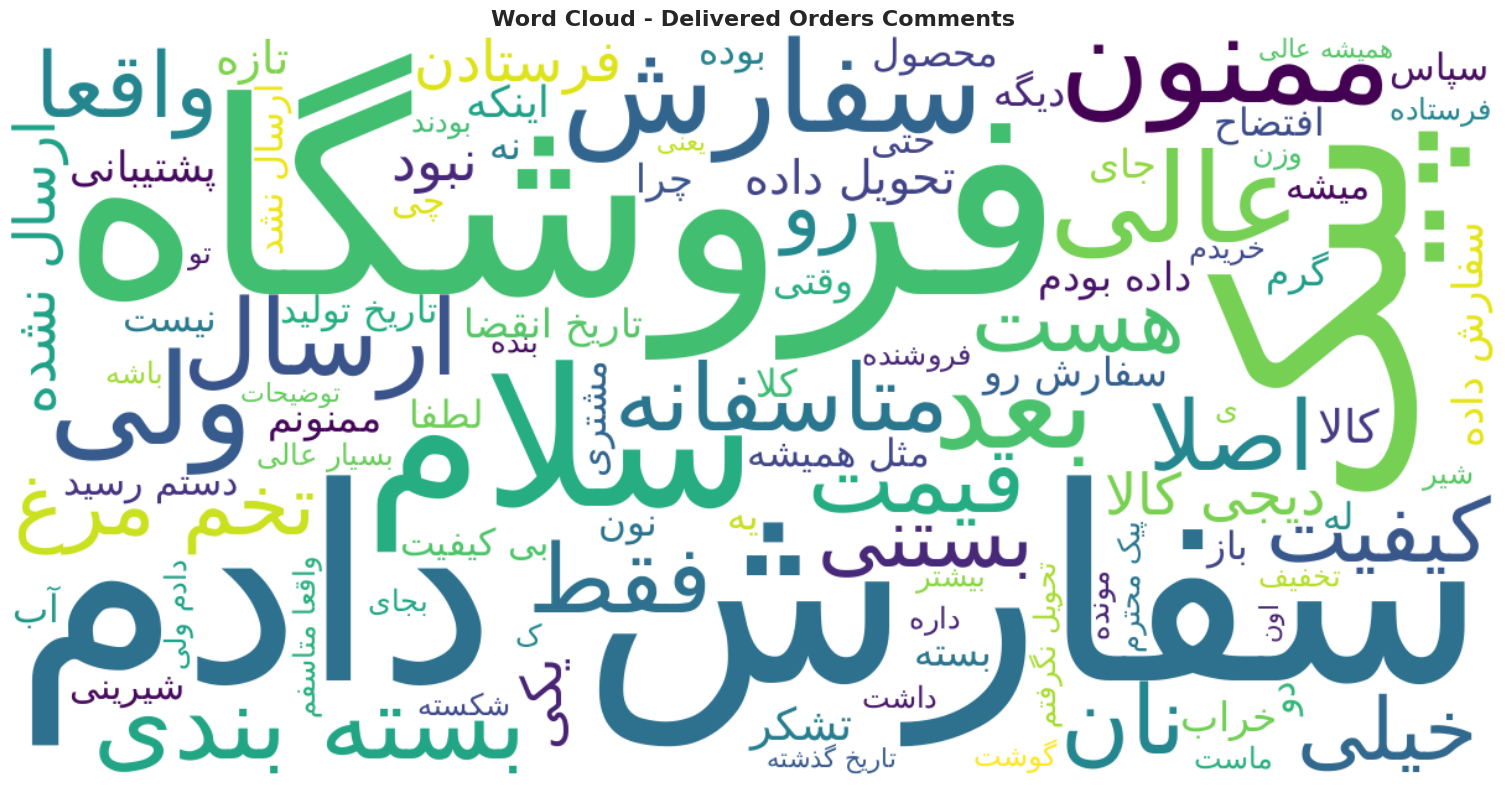

In [12]:
# Word Cloud
if WORDCLOUD_AVAILABLE:
    print('='*70)
    print('☁️ WORD CLOUD - Comments Analysis')
    print('='*70)
    
    # Combine all comments
    all_comments_text = ' '.join(delivered_comments['description'].dropna().astype(str))
    
    # Persian stopwords (basic list)
    persian_stopwords = {
        'و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای',
        'آن', 'یک', 'خود', 'تا', 'کرد', 'بر', 'هم', 'نیز', 'گفت', 'می',
        'شد', 'شده', 'بود', 'دارد', 'ها', 'های', 'شود', 'کند', 'یا',
        'اما', 'باید', 'هر', 'او', 'ما', 'من', 'شما', 'ای', 'اگر',
        'بودن', 'کردن', 'شدن', 'داشتن', 'خوب', 'بد', 'همه', 'چون'
    }
    
    # Create word cloud
    # Use a font that supports Persian
    try:
        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            stopwords=persian_stopwords,
            max_words=100,
            font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',  # Adjust font path
            colormap='viridis'
        ).generate(all_comments_text)
        
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title('Word Cloud - Delivered Orders Comments', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Warning: Could not create word cloud: {e}')
        print('Showing word frequency instead...')
        
        # Alternative: Word frequency
        words = all_comments_text.split()
        words = [w for w in words if w not in persian_stopwords and len(w) > 2]
        word_freq = Counter(words).most_common(30)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        words_list = [w[0] for w in word_freq]
        counts = [w[1] for w in word_freq]
        ax.barh(range(len(word_freq)), counts, color=COLORS['primary'])
        ax.set_yticks(range(len(word_freq)))
        ax.set_yticklabels(words_list)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency')
        ax.set_title('Top 30 Most Frequent Words in Comments')
        plt.tight_layout()
        plt.show()
else:
    print('WordCloud not available. Install with: pip install wordcloud')

☁️  WORD CLOUD - Comments Analysis


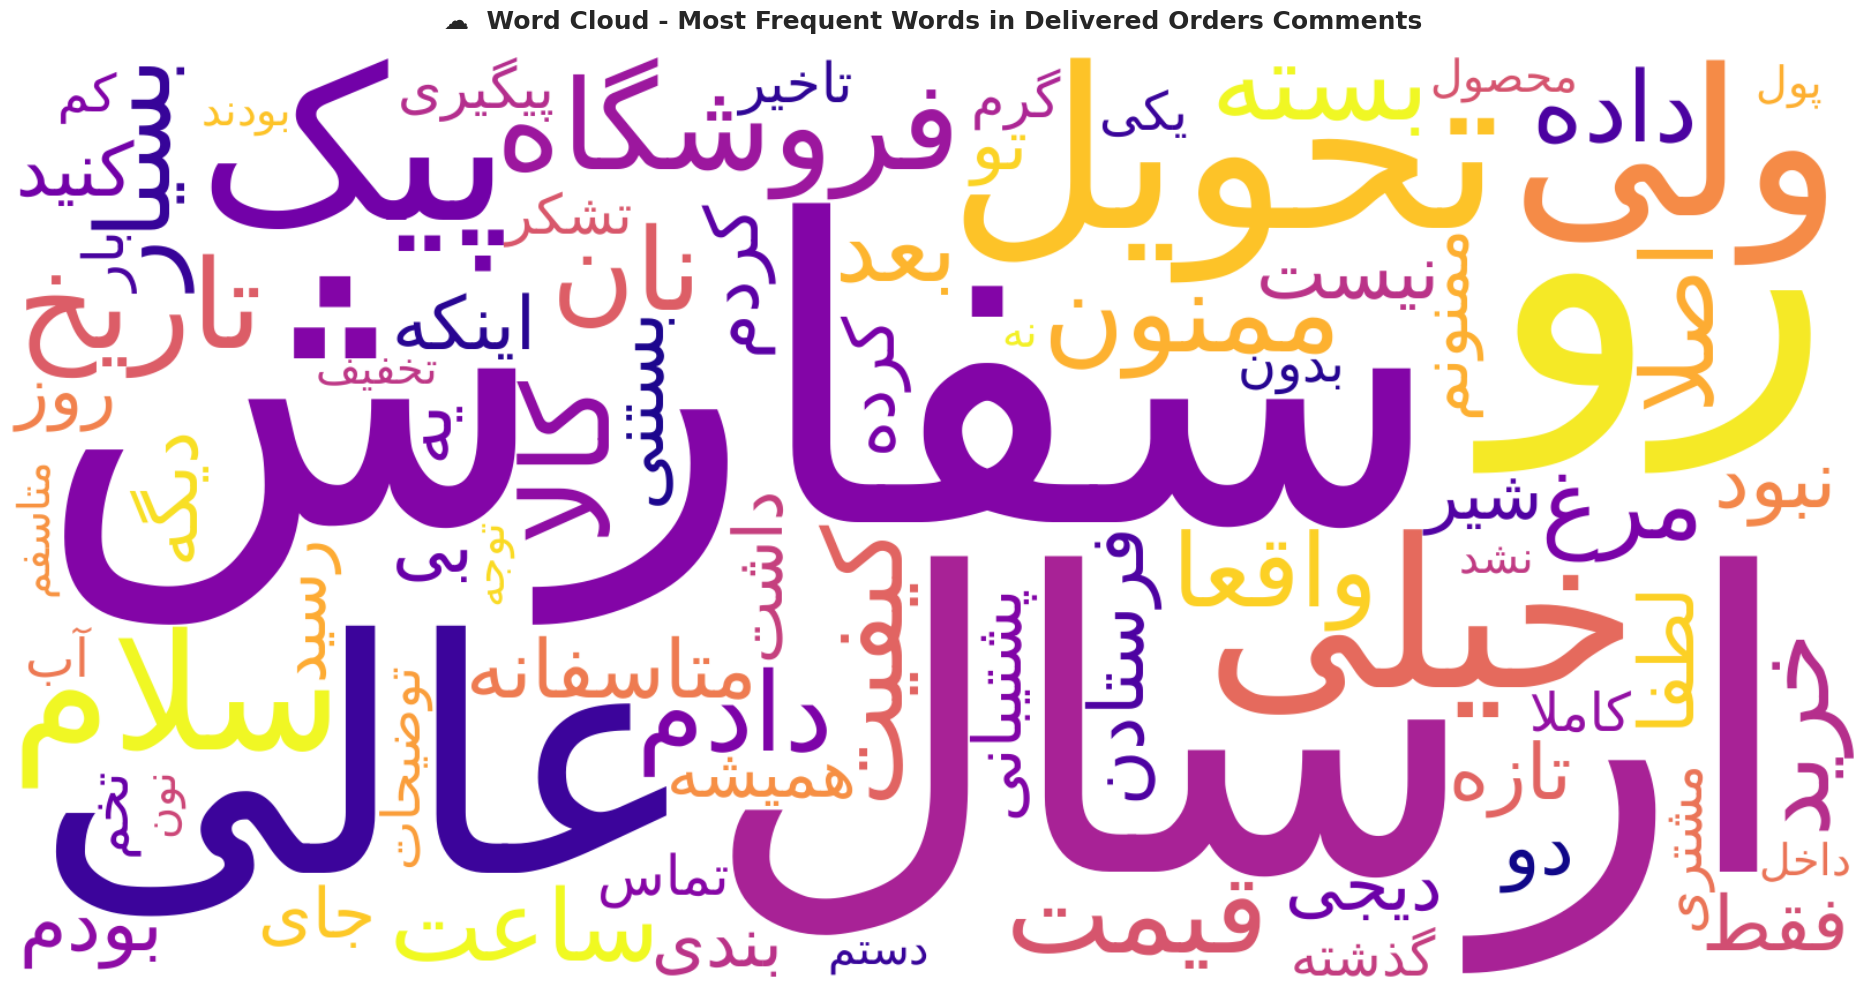

✅ Word cloud generated successfully with 80 words


In [15]:
import os
# Word Cloud with Persian and Emoji support
if WORDCLOUD_AVAILABLE:
    print('='*70)
    print('☁️  WORD CLOUD - Comments Analysis')
    print('='*70)

    # Import required libraries for Persian text
    try:
        from arabic_reshaper import arabic_reshaper
        from bidi.algorithm import get_display
        PERSIAN_SUPPORT = True
    except ImportError:
        print('⚠️  Warning: Install arabic-reshaper and python-bidi for better Persian support')
        print('   pip install arabic-reshaper python-bidi')
        PERSIAN_SUPPORT = False

    # Combine all comments
    all_comments_text = ' '.join(delivered_comments['description'].dropna().astype(str))

    # Extended Persian stopwords
    persian_stopwords = {
        'و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای',
        'آن', 'یک', 'خود', 'تا', 'کرد', 'بر', 'هم', 'نیز', 'گفت', 'می',
        'شد', 'شده', 'بود', 'دارد', 'ها', 'های', 'شود', 'کند', 'یا',
        'اما', 'باید', 'هر', 'او', 'ما', 'من', 'شما', 'ای', 'اگر',
        'بودن', 'کردن', 'شدن', 'داشتن', 'خوب', 'بد', 'همه', 'چون',
        'کنند', 'هست', 'هستند', 'دیگر', 'غیر', 'بین', 'پیش', 'پس',
        'چه', 'چیز', 'روی', 'گیرد', 'نشده', 'چند', 'چرا', 'البته'
    }

    # Try multiple Persian fonts (in order of preference)
    persian_fonts = [
        'C:/Windows/Fonts/arial.ttf',  # Windows
        '/System/Library/Fonts/Supplemental/Arial.ttf',  # macOS
        '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',  # Linux
        'arial.ttf',  # System font
    ]

    font_path = None
    for font in persian_fonts:
        if os.path.exists(font):
            font_path = font
            break

    # Create word cloud
    try:
        # Configure wordcloud with Persian support
        wc_config = {
            'width': 1600,
            'height': 800,
            'background_color': 'white',
            'stopwords': persian_stopwords,
            'max_words': 80,
            'colormap': 'plasma',  # More vibrant colors
            'relative_scaling': 0.5,
            'min_font_size': 10,
            'prefer_horizontal': 0.7,
            'collocations': False,  # Avoid repeated phrases
        }

        if font_path:
            wc_config['font_path'] = font_path

        wordcloud = WordCloud(**wc_config).generate(all_comments_text)

        # Plot with better styling
        fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

        # Title with emoji support
        title_text = '☁️  Word Cloud - Most Frequent Words in Delivered Orders Comments'
        ax.set_title(title_text, fontsize=18, fontweight='bold', pad=20)

        plt.tight_layout(pad=1)
        plt.show()

        print(f'✅ Word cloud generated successfully with {len(wordcloud.words_)} words')

    except Exception as e:
        print(f'⚠️  Warning: Could not create word cloud: {e}')
        print('📊 Showing word frequency bar chart instead...')

        # Alternative: Enhanced word frequency chart
        from collections import Counter

        # Clean and tokenize
        words = all_comments_text.split()
        words = [w.strip() for w in words if w.strip() not in persian_stopwords and len(w.strip()) > 2]
        word_freq = Counter(words).most_common(30)

        if not word_freq:
            print('❌ No words found to display')
        else:
            fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')

            words_list = [w[0] for w in word_freq]
            counts = [w[1] for w in word_freq]

            # Reshape Persian text if support available
            if PERSIAN_SUPPORT:
                words_list = [get_display(arabic_reshaper.reshape(w)) for w in words_list]

            # Create gradient colors
            colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(word_freq)))

            bars = ax.barh(range(len(word_freq)), counts, color=colors, edgecolor='black', linewidth=0.5)

            # Add value labels on bars
            for i, (bar, count) in enumerate(zip(bars, counts)):
                ax.text(count + max(counts)*0.01, i, str(count),
                       va='center', fontsize=10, fontweight='bold')

            ax.set_yticks(range(len(word_freq)))
            ax.set_yticklabels(words_list, fontsize=11)
            ax.invert_yaxis()
            ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
            ax.set_title('📊 Top 30 Most Frequent Words in Comments',
                        fontsize=16, fontweight='bold', pad=15)
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.set_axisbelow(True)

            plt.tight_layout()
            plt.show()

            print(f'✅ Bar chart generated with {len(word_freq)} words')
else:
    print('❌ WordCloud library not available')
    print('📦 Install with: pip install wordcloud')
    print('📦 For Persian support: pip install arabic-reshaper python-bidi')


☁️  WORD CLOUD - Comments Analysis


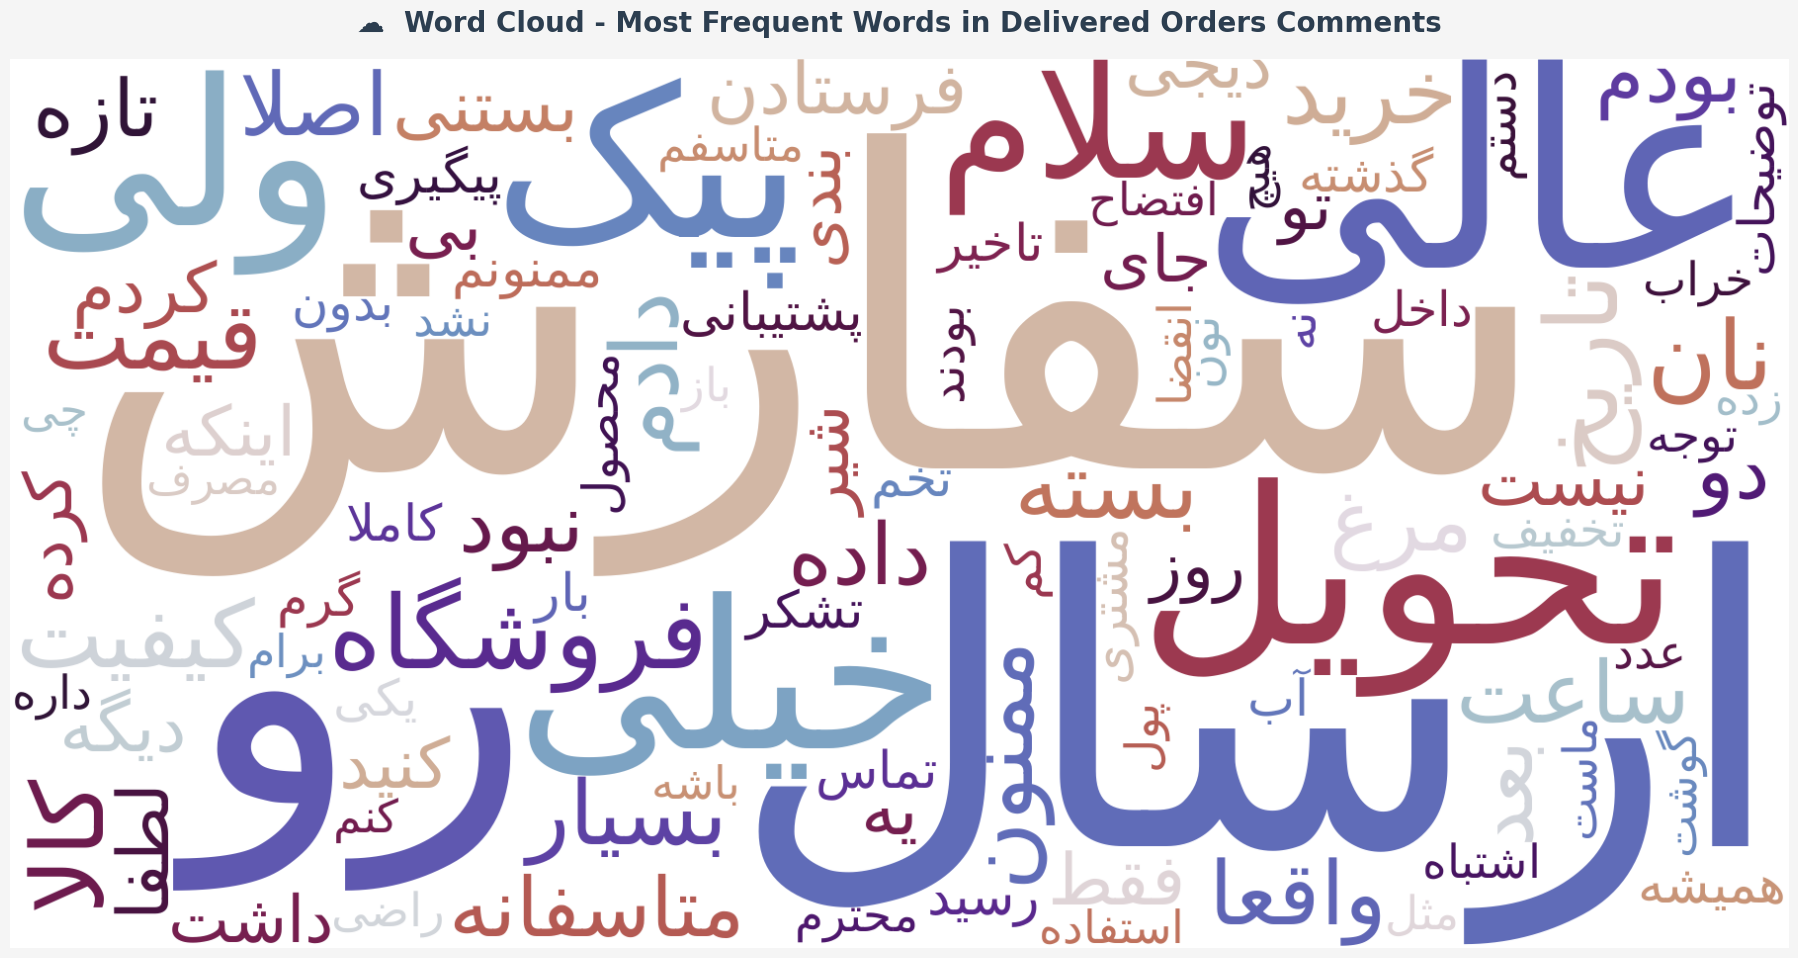

✅ Word cloud generated successfully!
📊 Total unique words: 100

🔝 Top 10 words:
   1. سفارش: 1.000
   2. ارسال: 0.976
   3. رو: 0.700
   4. عالی: 0.577
   5. تحویل: 0.511
   6. پیک: 0.458
   7. خیلی: 0.440
   8. ولی: 0.425
   9. سلام: 0.399
   10. فروشگاه: 0.395


In [16]:
# Enhanced Word Cloud with Persian Support
if WORDCLOUD_AVAILABLE:
    print('='*70)
    print('☁️  WORD CLOUD - Comments Analysis')
    print('='*70)

    # Import Persian text support
    try:
        from arabic_reshaper import arabic_reshaper
        from bidi.algorithm import get_display
        PERSIAN_SUPPORT = True
    except ImportError:
        print('⚠️  For better Persian display: pip install arabic-reshaper python-bidi')
        PERSIAN_SUPPORT = False

    # Combine all comments
    all_comments_text = ' '.join(delivered_comments['description'].dropna().astype(str))

    # Extended Persian stopwords
    persian_stopwords = {
        'و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای',
        'آن', 'یک', 'خود', 'تا', 'کرد', 'بر', 'هم', 'نیز', 'گفت', 'می',
        'شد', 'شده', 'بود', 'دارد', 'ها', 'های', 'شود', 'کند', 'یا',
        'اما', 'باید', 'هر', 'او', 'ما', 'من', 'شما', 'ای', 'اگر',
        'بودن', 'کردن', 'شدن', 'داشتن', 'خوب', 'بد', 'همه', 'چون',
        'کنند', 'هست', 'هستند', 'دیگر', 'غیر', 'بین', 'پیش', 'پس',
        'چه', 'چیز', 'روی', 'گیرد', 'نشده', 'چند', 'چرا', 'البته'
    }

    try:
        # Find suitable Persian font
        import os
        persian_fonts = [
            '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
            '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
            '/usr/share/fonts/TTF/DejaVuSans.ttf',
            '/System/Library/Fonts/Supplemental/Arial.ttf',
            'arial.ttf'
        ]

        font_path = None
        for font in persian_fonts:
            if os.path.exists(font):
                font_path = font
                break

        # Create word cloud with optimized settings
        wordcloud = WordCloud(
            width=1800,
            height=900,
            background_color='white',
            stopwords=persian_stopwords,
            max_words=100,
            font_path=font_path,
            colormap='twilight_shifted',  # Beautiful color scheme
            relative_scaling=0.4,
            min_font_size=12,
            prefer_horizontal=0.8,
            collocations=False,
            contour_width=0,
            contour_color='steelblue',
            random_state=42
        ).generate(all_comments_text)

        # Create beautiful visualization
        fig, ax = plt.subplots(figsize=(20, 10), facecolor='#f5f5f5')
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title('☁️  Word Cloud - Most Frequent Words in Delivered Orders Comments',
                    fontsize=20, fontweight='bold', pad=20, color='#2c3e50')

        # Add subtle border
        for spine in ax.spines.values():
            spine.set_visible(False)

        plt.tight_layout(pad=2)
        plt.show()

        print(f'✅ Word cloud generated successfully!')
        print(f'📊 Total unique words: {len(wordcloud.words_)}')

        # Show top 10 words
        top_words = list(wordcloud.words_.items())[:10]
        print('\n🔝 Top 10 words:')
        for i, (word, freq) in enumerate(top_words, 1):
            print(f'   {i}. {word}: {freq:.3f}')

    except Exception as e:
        print(f'⚠️  Error creating word cloud: {e}')
        print(f'🔍 Error type: {type(e).__name__}')

        # Show detailed error for debugging
        import traceback
        print('\n📋 Detailed error:')
        traceback.print_exc()

        # Fallback to bar chart
        print('\n📊 Showing bar chart instead...')

        from collections import Counter
        words = all_comments_text.split()
        words = [w.strip() for w in words if w.strip() not in persian_stopwords and len(w.strip()) > 2]
        word_freq = Counter(words).most_common(25)

        if word_freq:
            fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')

            words_list = [w[0] for w in word_freq]
            counts = [w[1] for w in word_freq]

            # Reshape Persian text
            if PERSIAN_SUPPORT:
                words_list = [get_display(arabic_reshaper.reshape(w)) for w in words_list]

            # Gradient colors
            colors = plt.cm.plasma(np.linspace(0.2, 0.95, len(word_freq)))

            bars = ax.barh(range(len(word_freq)), counts, color=colors,
                          edgecolor='#2c3e50', linewidth=0.8, alpha=0.9)

            # Add value labels
            for i, (bar, count) in enumerate(zip(bars, counts)):
                ax.text(count + max(counts)*0.015, i, f'{count}',
                       va='center', fontsize=11, fontweight='bold', color='#2c3e50')

            ax.set_yticks(range(len(word_freq)))
            ax.set_yticklabels(words_list, fontsize=12)
            ax.invert_yaxis()
            ax.set_xlabel('Frequency', fontsize=13, fontweight='bold')
            ax.set_title('📊 Top 25 Most Frequent Words in Comments',
                        fontsize=18, fontweight='bold', pad=15, color='#2c3e50')
            ax.grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.8)
            ax.set_axisbelow(True)
            ax.set_facecolor('#fafafa')

            plt.tight_layout()
            plt.show()
            print(f'✅ Bar chart created with {len(word_freq)} words')
else:
    print('❌ WordCloud not installed')
    print('📦 Install: pip install wordcloud "numpy<2.0"')


🔤 KEYWORD ANALYSIS

Keyword Category Counts:
   Delivery       :   50,758
   Quality        :   44,077
   Positive       :   35,549
   Negative       :   14,143
   Price          :   12,171
   Service        :    4,669


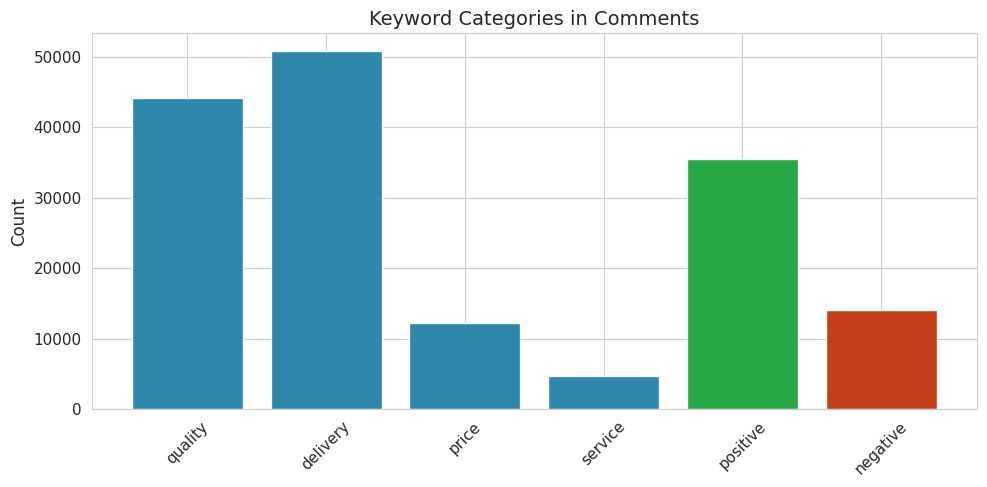

In [17]:
# Simple keyword analysis
print('='*70)
print('🔤 KEYWORD ANALYSIS')
print('='*70)

# Define keyword categories
keyword_categories = {
    'quality': ['کیفیت', 'تازه', 'خراب', 'فاسد', 'خوب', 'عالی', 'بد'],
    'delivery': ['تحویل', 'دیر', 'سریع', 'زمان', 'ارسال', 'پیک', 'رسید'],
    'price': ['قیمت', 'گران', 'ارزان', 'تخفیف', 'هزینه'],
    'service': ['پشتیبانی', 'سرویس', 'خدمات', 'پاسخ', 'رفتار'],
    'positive': ['ممنون', 'عالی', 'خوب', 'راضی', 'تشکر', 'لذت'],
    'negative': ['بد', 'خراب', 'نارضایتی', 'مشکل', 'ناراحت', 'شکایت']
}

# Count keywords in comments
keyword_counts = {}
for category, keywords in keyword_categories.items():
    count = 0
    for keyword in keywords:
        count += all_comments_text.count(keyword)
    keyword_counts[category] = count

# Display
print('\nKeyword Category Counts:')
for category, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
    print(f'   {category.capitalize():15s}: {count:>8,}')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
categories = list(keyword_counts.keys())
counts = list(keyword_counts.values())
colors_bar = [COLORS['success'] if c in ['positive'] else 
              COLORS['danger'] if c in ['negative'] else 
              COLORS['primary'] for c in categories]
ax.bar(categories, counts, color=colors_bar)
ax.set_ylabel('Count')
ax.set_title('Keyword Categories in Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4️⃣ Churn Rate Trend Over Time

بررسی ترند نرخ چرن در گذر زمان

In [18]:
print('='*70)
print('📉 CHURN RATE TREND ANALYSIS')
print('='*70)

# For each week/month, calculate:
# 1. Active users that week
# 2. How many didn't return in next 30 days

# Create user-level last order date
user_last_order = master_df.groupby('user_id')['order_date'].max().reset_index()
user_last_order.columns = ['user_id', 'last_order_date']

# Get unique users per week
master_df['week_start'] = master_df['order_date'].dt.to_period('W').dt.start_time

# For each user, find their first and last activity week
user_activity = master_df.groupby('user_id').agg({
    'order_date': ['min', 'max'],
    'order_id': 'count'
}).reset_index()
user_activity.columns = ['user_id', 'first_order', 'last_order', 'total_orders']

print(f'Total Users: {len(user_activity):,}')

📉 CHURN RATE TREND ANALYSIS
Total Users: 375,998


In [19]:
# Calculate weekly churn rate
# Churn: users active in week W who don't return in next 30 days

weekly_users = master_df.groupby('week_start')['user_id'].nunique().reset_index()
weekly_users.columns = ['week_start', 'active_users']

# Calculate churn for each week (30-day forward looking)
churn_rates = []

for week_date in sorted(weekly_users['week_start'].unique())[:-5]:  # Skip last 5 weeks
    # Users active this week
    week_users = master_df[master_df['week_start'] == week_date]['user_id'].unique()
    
    # Check who returned in next 30 days
    end_date = week_date + pd.Timedelta(days=30)
    future_orders = master_df[
        (master_df['order_date'] > week_date + pd.Timedelta(days=6)) &  # After this week
        (master_df['order_date'] <= end_date)
    ]
    returning_users = set(future_orders['user_id'].unique())
    
    # Churned users
    churned = len([u for u in week_users if u not in returning_users])
    churn_rate = churned / len(week_users) * 100
    
    churn_rates.append({
        'week': week_date,
        'week_jalali': to_jalali_year_month(week_date),
        'active_users': len(week_users),
        'churned_users': churned,
        'churn_rate': churn_rate
    })

churn_trend_df = pd.DataFrame(churn_rates)
print(f'Weekly Churn Trend ({len(churn_trend_df)} weeks):')
display(churn_trend_df.head(10))

Weekly Churn Trend (22 weeks):


,week,week_jalali,active_users,churned_users,churn_rate
0,2025-03-10,1403-12,11861,3861,32.55
1,2025-03-17,1403-12,47108,18626,39.54
2,2025-03-24,1404-01,44821,17638,39.35
3,2025-03-31,1404-01,43596,15283,35.06
4,2025-04-07,1404-01,58862,23159,39.34
5,2025-04-14,1404-01,57141,23258,40.70
6,2025-04-21,1404-02,51291,18059,35.21
7,2025-04-28,1404-02,60130,20822,34.63
8,2025-05-05,1404-02,60945,20313,33.33
9,2025-05-12,1404-02,62644,20369,32.52


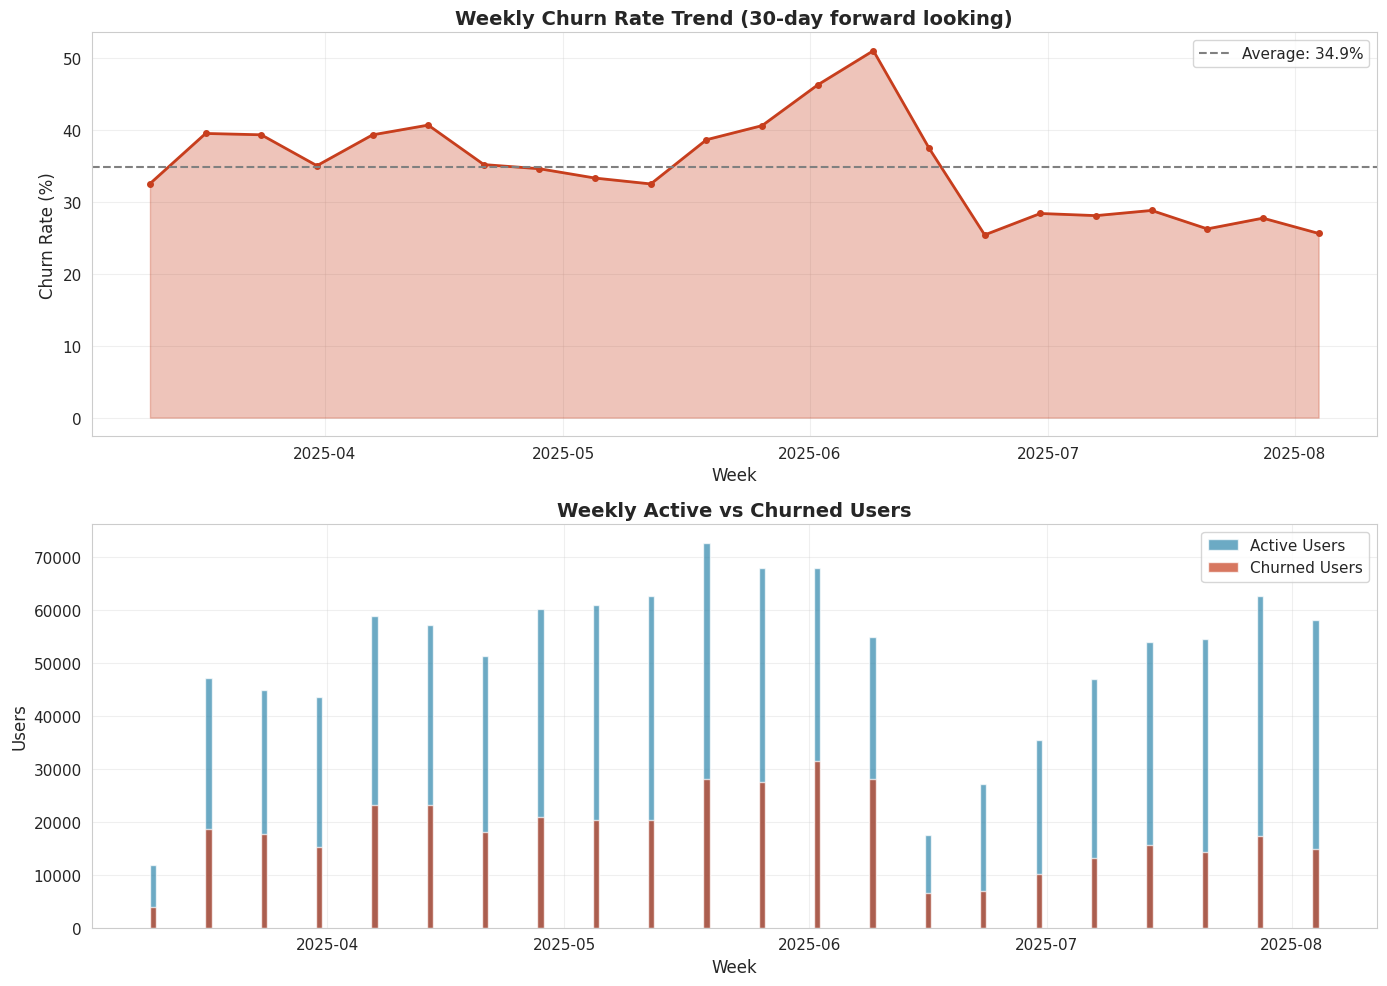

In [20]:
# Visualize churn trend
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Churn Rate over time
ax1 = axes[0]
ax1.plot(churn_trend_df['week'], churn_trend_df['churn_rate'], 
         marker='o', linewidth=2, color=COLORS['danger'], markersize=4)
ax1.axhline(y=churn_trend_df['churn_rate'].mean(), color='gray', 
            linestyle='--', label=f'Average: {churn_trend_df["churn_rate"].mean():.1f}%')
ax1.fill_between(churn_trend_df['week'], churn_trend_df['churn_rate'], 
                 alpha=0.3, color=COLORS['danger'])
ax1.set_xlabel('Week')
ax1.set_ylabel('Churn Rate (%)')
ax1.set_title('Weekly Churn Rate Trend (30-day forward looking)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Active users over time
ax2 = axes[1]
ax2.bar(churn_trend_df['week'], churn_trend_df['active_users'], 
        color=COLORS['primary'], alpha=0.7, label='Active Users')
ax2.bar(churn_trend_df['week'], churn_trend_df['churned_users'], 
        color=COLORS['danger'], alpha=0.7, label='Churned Users')
ax2.set_xlabel('Week')
ax2.set_ylabel('Users')
ax2.set_title('Weekly Active vs Churned Users', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Monthly churn trend
print('='*70)
print('📅 MONTHLY CHURN TREND')
print('='*70)

monthly_churn = churn_trend_df.copy()
monthly_churn['month'] = monthly_churn['week'].dt.to_period('M')
monthly_agg = monthly_churn.groupby('month').agg({
    'active_users': 'sum',
    'churned_users': 'sum'
}).reset_index()
monthly_agg['churn_rate'] = monthly_agg['churned_users'] / monthly_agg['active_users'] * 100

print('\nMonthly Summary:')
display(monthly_agg)

📅 MONTHLY CHURN TREND

Monthly Summary:


,month,active_users,churned_users,churn_rate
0,2025-03,147386,55408,37.59
1,2025-04,227424,85298,37.51
2,2025-05,264136,96359,36.48
3,2025-06,202942,83030,40.91
4,2025-07,218088,60459,27.72
5,2025-08,58050,14879,25.63


## 5️⃣ Conversion & Retention Analysis

تحلیل نرخ تبدیل و نگهداشت مشتریان

In [22]:
print('='*70)
print('🔄 CONVERSION & RETENTION ANALYSIS')
print('='*70)

# Order count distribution
order_counts = master_df.groupby('user_id').size().reset_index(name='order_count')

# Conversion funnel
conversion_funnel = {
    '1 Order (One-time)': (order_counts['order_count'] == 1).sum(),
    '2+ Orders (Repeat)': (order_counts['order_count'] >= 2).sum(),
    '3+ Orders': (order_counts['order_count'] >= 3).sum(),
    '5+ Orders': (order_counts['order_count'] >= 5).sum(),
    '10+ Orders': (order_counts['order_count'] >= 10).sum(),
    '20+ Orders': (order_counts['order_count'] >= 20).sum(),
    '50+ Orders': (order_counts['order_count'] >= 50).sum(),
}

print('\n📊 CONVERSION FUNNEL:')
total_users = len(order_counts)
for stage, count in conversion_funnel.items():
    pct = count / total_users * 100
    print(f'   {stage:25s}: {count:>10,} ({pct:>6.2f}%)')

🔄 CONVERSION & RETENTION ANALYSIS

📊 CONVERSION FUNNEL:
   1 Order (One-time)       :    168,769 ( 44.89%)
   2+ Orders (Repeat)       :    207,229 ( 55.11%)
   3+ Orders                :    166,325 ( 44.24%)
   5+ Orders                :    123,610 ( 32.88%)
   10+ Orders               :     73,574 ( 19.57%)
   20+ Orders               :     35,513 (  9.44%)
   50+ Orders               :      7,945 (  2.11%)


In [23]:
# First-to-Second Order Conversion (Key Metric!)
print('='*70)
print('🎯 FIRST-TO-SECOND ORDER CONVERSION')
print('='*70)

one_time_users = (order_counts['order_count'] == 1).sum()
repeat_users = (order_counts['order_count'] >= 2).sum()
first_to_second_rate = repeat_users / total_users * 100

print(f'''
   One-time Users:         {one_time_users:>10,} ({one_time_users/total_users*100:.1f}%)
   Repeat Users (2+):      {repeat_users:>10,} ({first_to_second_rate:.1f}%)
   
   🎯 First-to-Second Conversion Rate: {first_to_second_rate:.2f}%
''')

🎯 FIRST-TO-SECOND ORDER CONVERSION

   One-time Users:            168,769 (44.9%)
   Repeat Users (2+):         207,229 (55.1%)
   
   🎯 First-to-Second Conversion Rate: 55.11%



📈 ORDER-TO-ORDER RETENTION


,from_order,to_order,users_at_n,users_at_n_plus_1,retention_rate
0,1,2,375998,207229,55.11
1,2,3,207229,166325,80.26
2,3,4,166325,141481,85.06
3,4,5,141481,123610,87.37
4,5,6,123610,109429,88.53
5,6,7,109429,98146,89.69
6,7,8,98146,88697,90.37
7,8,9,88697,80516,90.78
8,9,10,80516,73574,91.38
9,10,11,73574,67638,91.93


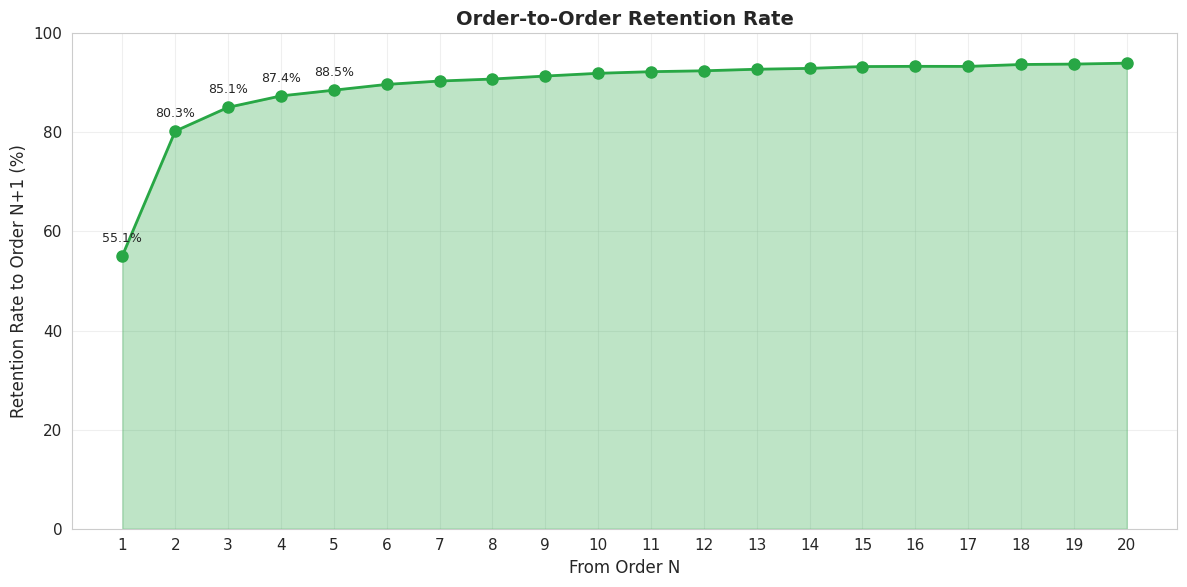

In [24]:
# Retention by order number
print('='*70)
print('📈 ORDER-TO-ORDER RETENTION')
print('='*70)

# For each order N, what % of users come back for order N+1?
retention_rates = []

for n in range(1, 21):
    users_with_n = (order_counts['order_count'] >= n).sum()
    users_with_n_plus_1 = (order_counts['order_count'] >= n + 1).sum()
    
    if users_with_n > 0:
        retention = users_with_n_plus_1 / users_with_n * 100
        retention_rates.append({
            'from_order': n,
            'to_order': n + 1,
            'users_at_n': users_with_n,
            'users_at_n_plus_1': users_with_n_plus_1,
            'retention_rate': retention
        })

retention_df = pd.DataFrame(retention_rates)
display(retention_df)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(retention_df['from_order'], retention_df['retention_rate'], 
        marker='o', linewidth=2, color=COLORS['success'], markersize=8)
ax.fill_between(retention_df['from_order'], retention_df['retention_rate'], 
                alpha=0.3, color=COLORS['success'])
ax.set_xlabel('From Order N')
ax.set_ylabel('Retention Rate to Order N+1 (%)')
ax.set_title('Order-to-Order Retention Rate', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 21))
ax.set_ylim([0, 100])
ax.grid(True, alpha=0.3)

# Add annotations
for i, row in retention_df.iterrows():
    if row['from_order'] <= 5:
        ax.annotate(f"{row['retention_rate']:.1f}%", 
                    (row['from_order'], row['retention_rate']),
                    textcoords='offset points', xytext=(0, 10),
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6️⃣ Customer Lifetime Analysis

تحلیل چرخه عمر مشتری

In [25]:
print('='*70)
print('⏱️ CUSTOMER LIFETIME ANALYSIS')
print('='*70)

# Calculate customer lifetime (first to last order)
user_lifetime = master_df.groupby('user_id').agg({
    'order_date': ['min', 'max', 'count']
}).reset_index()
user_lifetime.columns = ['user_id', 'first_order', 'last_order', 'total_orders']
user_lifetime['lifetime_days'] = (user_lifetime['last_order'] - user_lifetime['first_order']).dt.days
user_lifetime['avg_days_between_orders'] = user_lifetime['lifetime_days'] / (user_lifetime['total_orders'] - 1)
user_lifetime['avg_days_between_orders'] = user_lifetime['avg_days_between_orders'].replace([np.inf, -np.inf], np.nan)

# Summary stats
print('\n📊 LIFETIME STATISTICS (all users):')
print(user_lifetime[['lifetime_days', 'total_orders', 'avg_days_between_orders']].describe())

⏱️ CUSTOMER LIFETIME ANALYSIS

📊 LIFETIME STATISTICS (all users):
       lifetime_days  total_orders  avg_days_between_orders
count      375998.00     375998.00                207229.00
mean           52.15          7.23                    19.79
std            64.63         40.31                    24.92
min             0.00          1.00                     0.00
25%             0.00          1.00                     5.29
50%             5.00          2.00                    11.36
75%           115.00          7.00                    23.60
max           180.00      23079.00                   179.00


In [26]:
# Lifetime distribution by order count segments
def get_segment(n):
    if n == 1: return '1 Order'
    elif n <= 4: return '2-4 Orders'
    elif n <= 10: return '5-10 Orders'
    elif n <= 30: return '11-30 Orders'
    else: return '30+ Orders'

user_lifetime['segment'] = user_lifetime['total_orders'].apply(get_segment)

# Segment summary
segment_lifetime = user_lifetime.groupby('segment').agg({
    'user_id': 'count',
    'lifetime_days': ['mean', 'median'],
    'total_orders': 'mean',
    'avg_days_between_orders': 'mean'
}).round(2)
segment_lifetime.columns = ['Users', 'Avg Lifetime (days)', 'Median Lifetime (days)', 
                            'Avg Orders', 'Avg Days Between Orders']

# Reorder segments
segment_order = ['1 Order', '2-4 Orders', '5-10 Orders', '11-30 Orders', '30+ Orders']
segment_lifetime = segment_lifetime.reindex(segment_order)

print('\n📊 LIFETIME BY SEGMENT:')
display(segment_lifetime)


📊 LIFETIME BY SEGMENT:


,Users,Avg Lifetime (days),Median Lifetime (days),Avg Orders,Avg Days Between Orders
segment,,,,,
1 Order,168769,0.00,0.00,1.00,NaN
2-4 Orders,83619,50.32,33.00,2.72,31.25
5-10 Orders,55972,101.50,110.00,7.00,17.71
11-30 Orders,48491,136.85,147.00,17.69,8.88
30+ Orders,19147,160.99,169.00,56.07,3.51


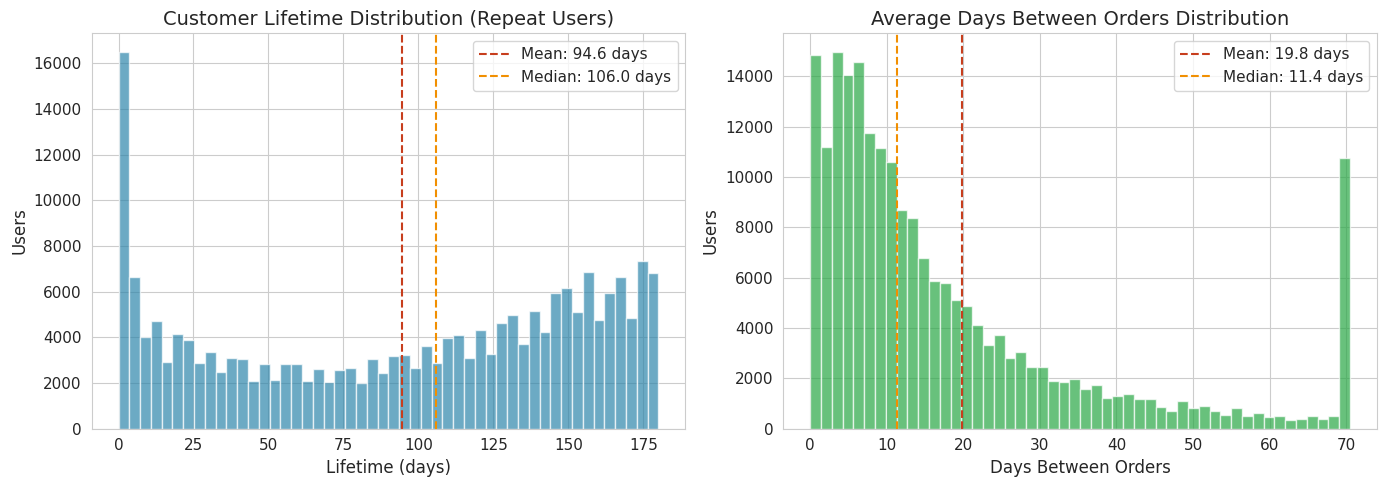

In [27]:
# Visualize lifetime distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lifetime distribution (excluding 0 = one-time users)
ax1 = axes[0]
repeat_users_lifetime = user_lifetime[user_lifetime['total_orders'] >= 2]['lifetime_days']
ax1.hist(repeat_users_lifetime, bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.7)
ax1.axvline(x=repeat_users_lifetime.mean(), color=COLORS['danger'], 
            linestyle='--', label=f'Mean: {repeat_users_lifetime.mean():.1f} days')
ax1.axvline(x=repeat_users_lifetime.median(), color=COLORS['warning'], 
            linestyle='--', label=f'Median: {repeat_users_lifetime.median():.1f} days')
ax1.set_xlabel('Lifetime (days)')
ax1.set_ylabel('Users')
ax1.set_title('Customer Lifetime Distribution (Repeat Users)')
ax1.legend()

# Average days between orders
ax2 = axes[1]
avg_interval = user_lifetime[user_lifetime['avg_days_between_orders'].notna()]['avg_days_between_orders']
avg_interval_clipped = avg_interval.clip(upper=avg_interval.quantile(0.95))  # Clip outliers
ax2.hist(avg_interval_clipped, bins=50, color=COLORS['success'], edgecolor='white', alpha=0.7)
ax2.axvline(x=avg_interval.mean(), color=COLORS['danger'], 
            linestyle='--', label=f'Mean: {avg_interval.mean():.1f} days')
ax2.axvline(x=avg_interval.median(), color=COLORS['warning'], 
            linestyle='--', label=f'Median: {avg_interval.median():.1f} days')
ax2.set_xlabel('Days Between Orders')
ax2.set_ylabel('Users')
ax2.set_title('Average Days Between Orders Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

## 7️⃣ Customer Lifetime Value (CLV)

محاسبه ارزش طول عمر مشتری

**فرمول ساده CLV:**
```
CLV = Average Order Value × Purchase Frequency × Customer Lifespan
```

چون دیتای مالی نداریم، از تعداد سفارش به عنوان proxy استفاده می‌کنیم.

In [28]:
print('='*70)
print('💰 CUSTOMER LIFETIME VALUE (CLV) ANALYSIS')
print('='*70)

# Since we don't have revenue data, we'll use order count as a proxy for value
# CLV Proxy = Total Orders (assuming each order has similar value)

# Calculate CLV components
user_clv = user_lifetime.copy()

# Purchase Frequency (orders per month of lifetime)
user_clv['active_months'] = (user_clv['lifetime_days'] / 30).clip(lower=1)  # At least 1 month
user_clv['orders_per_month'] = user_clv['total_orders'] / user_clv['active_months']

# CLV Score (normalized)
# CLV = Total Orders × (1 + Frequency Bonus)
# Frequency Bonus rewards consistent buyers
user_clv['frequency_score'] = user_clv['orders_per_month'] / user_clv['orders_per_month'].mean()
user_clv['clv_score'] = user_clv['total_orders'] * (0.5 + 0.5 * user_clv['frequency_score'].clip(upper=2))

print('\n📊 CLV SCORE DISTRIBUTION:')
print(user_clv['clv_score'].describe())

💰 CUSTOMER LIFETIME VALUE (CLV) ANALYSIS

📊 CLV SCORE DISTRIBUTION:
count   375998.00
mean         9.23
std         60.49
min          0.71
25%          0.71
50%          1.85
75%          7.15
max      34618.50
Name: clv_score, dtype: float64


In [29]:
# CLV Segments
user_clv['clv_rank'] = user_clv['clv_score'].rank(method="first")
# user_clv['clv_log'] = np.log1p(user_clv['clv_score'])

user_clv['clv_segment'] = pd.qcut(
                                user_clv['clv_rank'],
                                q=5,
                                labels=['Bronze', 'Silver', 'Gold', 'Platinum',  'Diamond'],
                                duplicates='drop'
                                    )

# CLV segment summary
clv_summary = user_clv.groupby('clv_segment').agg({
    'user_id': 'count',
    'total_orders': 'mean',
    'lifetime_days': 'mean',
    'orders_per_month': 'mean',
    'clv_score': ['mean', 'min', 'max']
}).round(2)
clv_summary.columns = ['Users', 'Avg Orders', 'Avg Lifetime (days)', 
                       'Orders/Month', 'Avg CLV', 'Min CLV', 'Max CLV']

print('\n📊 CLV SEGMENTS:')
display(clv_summary)


📊 CLV SEGMENTS:


,Users,Avg Orders,Avg Lifetime (days),Orders/Month,Avg CLV,Min CLV,Max CLV
clv_segment,,,,,,,
Bronze,75200,1.00,0.00,1.00,0.71,0.71,0.71
Silver,75199,1.00,0.00,1.00,0.71,0.71,0.71
Gold,75200,2.01,42.46,1.32,1.57,0.71,2.81
Platinum,75199,5.60,83.98,2.40,5.48,2.81,10.01
Diamond,75200,26.55,134.29,6.11,37.69,10.01,34618.50


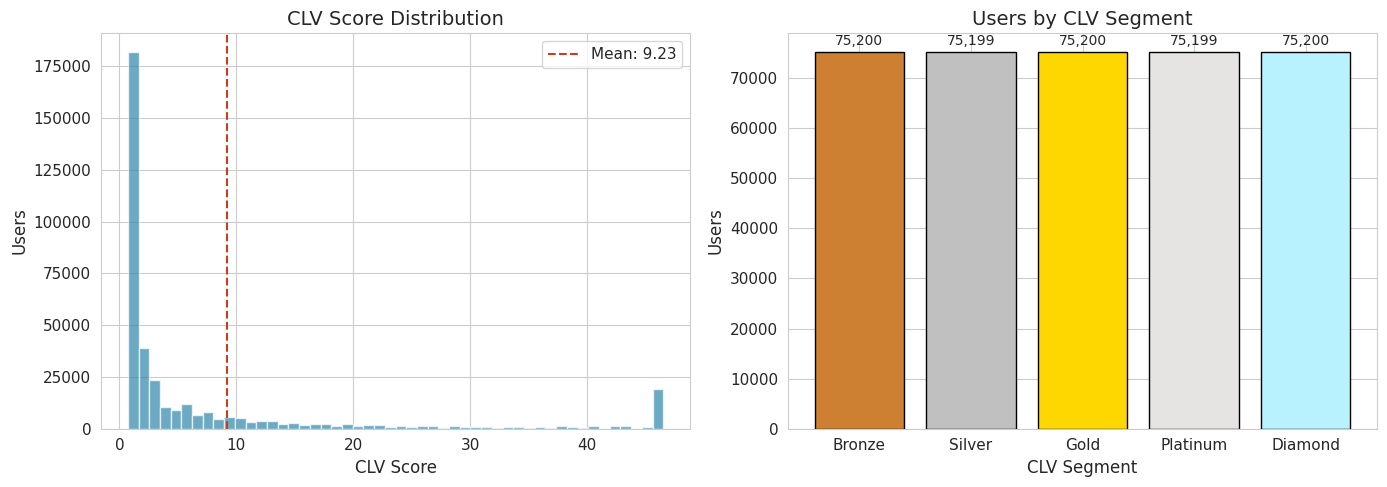

In [30]:
# CLV Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CLV Score distribution
ax1 = axes[0]
clv_clipped = user_clv['clv_score'].clip(upper=user_clv['clv_score'].quantile(0.95))
ax1.hist(clv_clipped, bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.7)
ax1.axvline(x=user_clv['clv_score'].mean(), color=COLORS['danger'], 
            linestyle='--', label=f'Mean: {user_clv["clv_score"].mean():.2f}')
ax1.set_xlabel('CLV Score')
ax1.set_ylabel('Users')
ax1.set_title('CLV Score Distribution')
ax1.legend()

# CLV Segment Distribution
ax2 = axes[1]
segment_counts = user_clv['clv_segment'].value_counts().reindex(
    ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond'])
colors_clv = ['#CD7F32', '#C0C0C0', '#FFD700', '#E5E4E2', '#B9F2FF']
ax2.bar(segment_counts.index, segment_counts.values, color=colors_clv, edgecolor='black')
ax2.set_xlabel('CLV Segment')
ax2.set_ylabel('Users')
ax2.set_title('Users by CLV Segment')

for i, v in enumerate(segment_counts.values):
    ax2.text(i, v + max(segment_counts.values)*0.02, f'{v:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [31]:
# Top CLV Users (VIP Customers)
print('='*70)
print('👑 TOP CLV CUSTOMERS (VIP)')
print('='*70)

top_clv_users = user_clv.nlargest(20, 'clv_score')[[
    'user_id', 'total_orders', 'lifetime_days', 'orders_per_month', 'clv_score', 'segment'
]]
top_clv_users = top_clv_users.rename(columns={'segment': 'frequency_segment'})
display(top_clv_users)

# VIP Statistics
vip_users = user_clv[user_clv['clv_segment'].isin(['Platinum', 'Diamond'])]
print(f'''
💎 VIP CUSTOMERS (Platinum + Diamond):
   Count:              {len(vip_users):,} ({len(vip_users)/len(user_clv)*100:.1f}% of users)
   Total Orders:       {vip_users['total_orders'].sum():,} ({vip_users['total_orders'].sum()/total_orders*100:.1f}% of orders)
   Avg Orders/User:    {vip_users['total_orders'].mean():.1f}
   Avg Lifetime:       {vip_users['lifetime_days'].mean():.0f} days
''')

👑 TOP CLV CUSTOMERS (VIP)


,user_id,total_orders,lifetime_days,orders_per_month,clv_score,frequency_segment
131192,20524543,23079,72,9616.25,34618.50,30+ Orders
228453,33115912,971,36,809.17,1456.50,30+ Orders
52990,547202,791,179,132.57,1186.50,30+ Orders
190464,31060336,696,180,116.00,1044.00,30+ Orders
207178,31282871,656,179,109.94,984.00,30+ Orders
315075,33829795,609,97,188.35,913.50,30+ Orders
225837,33033498,595,180,99.17,892.50,30+ Orders
86033,1674703,585,173,101.45,877.50,30+ Orders
197348,31128401,493,179,82.63,739.50,30+ Orders
108421,3254127,455,180,75.83,682.50,30+ Orders



💎 VIP CUSTOMERS (Platinum + Diamond):
   Count:              150,399 (40.0% of users)
   Total Orders:       2,418,151 (88.9% of orders)
   Avg Orders/User:    16.1
   Avg Lifetime:       109 days



## 8️⃣ Delivery Performance Deep Dive

تحلیل عمیق‌تر عملکرد تحویل

In [32]:
print('='*70)
print('🚚 DELIVERY PERFORMANCE ANALYSIS')
print('='*70)

# OTD by month
delivered_df = master_df[master_df['delivery_status'] == 'delivered'].copy()
delivered_df['month'] = delivered_df['order_date'].dt.to_period('M')

# Monthly OTD rate
monthly_otd = delivered_df[delivered_df['is_otd'].isin([0, 1])].groupby('month').agg({
    'is_otd': ['sum', 'count']
}).reset_index()
monthly_otd.columns = ['month', 'otd_count', 'total_delivered']
monthly_otd['otd_rate'] = monthly_otd['otd_count'] / monthly_otd['total_delivered'] * 100

print('\n📊 MONTHLY OTD RATE:')
display(monthly_otd)

🚚 DELIVERY PERFORMANCE ANALYSIS

📊 MONTHLY OTD RATE:


,month,otd_count,total_delivered,otd_rate
0,2025-03,145979,180132,81.04
1,2025-04,314412,378015,83.17
2,2025-05,425040,512430,82.95
3,2025-06,265957,322456,82.48
4,2025-07,316366,403469,78.41
5,2025-08,386635,541018,71.46
6,2025-09,164637,216465,76.06


In [33]:
# OTD vs Ratings correlation
print('='*70)
print('📊 OTD vs CUSTOMER SATISFACTION')
print('='*70)

# Compare ratings for OTD vs Non-OTD
otd_ratings = delivered_df[delivered_df['is_otd'] == 1][['rate_to_shop', 'rate_to_courier']].dropna()
non_otd_ratings = delivered_df[delivered_df['is_otd'] == 0][['rate_to_shop', 'rate_to_courier']].dropna()

print(f'''
📦 ON-TIME DELIVERY (OTD = 1):
   Shop Rating:     {otd_ratings['rate_to_shop'].mean():.2f} (n={len(otd_ratings):,})
   Courier Rating:  {otd_ratings['rate_to_courier'].mean():.2f}
   
📦 LATE DELIVERY (OTD = 0):
   Shop Rating:     {non_otd_ratings['rate_to_shop'].mean():.2f} (n={len(non_otd_ratings):,})
   Courier Rating:  {non_otd_ratings['rate_to_courier'].mean():.2f}
   
📉 IMPACT OF LATE DELIVERY:
   Shop Rating Drop:    {otd_ratings['rate_to_shop'].mean() - non_otd_ratings['rate_to_shop'].mean():.2f}
   Courier Rating Drop: {otd_ratings['rate_to_courier'].mean() - non_otd_ratings['rate_to_courier'].mean():.2f}
''')

📊 OTD vs CUSTOMER SATISFACTION

📦 ON-TIME DELIVERY (OTD = 1):
   Shop Rating:     4.52 (n=507,817)
   Courier Rating:  4.80
   
📦 LATE DELIVERY (OTD = 0):
   Shop Rating:     4.26 (n=142,403)
   Courier Rating:  4.38
   
📉 IMPACT OF LATE DELIVERY:
   Shop Rating Drop:    0.26
   Courier Rating Drop: 0.42



In [34]:
# Tickets vs OTD
print('='*70)
print('🎫 TICKETS vs ON-TIME DELIVERY')
print('='*70)

# Ticket rate for OTD vs Non-OTD
otd_orders = delivered_df[delivered_df['is_otd'] == 1]
non_otd_orders = delivered_df[delivered_df['is_otd'] == 0]

otd_ticket_rate = (otd_orders['crm_delivery_request_count'] > 0).mean() * 100
non_otd_ticket_rate = (non_otd_orders['crm_delivery_request_count'] > 0).mean() * 100

print(f'''
🎫 TICKET RATE COMPARISON:
   On-Time Orders:   {otd_ticket_rate:.2f}% have tickets
   Late Orders:      {non_otd_ticket_rate:.2f}% have tickets
   
   Late delivery increases ticket rate by: {non_otd_ticket_rate - otd_ticket_rate:.2f} percentage points
   That's a {(non_otd_ticket_rate / otd_ticket_rate - 1) * 100:.0f}% increase!
''')

🎫 TICKETS vs ON-TIME DELIVERY

🎫 TICKET RATE COMPARISON:
   On-Time Orders:   11.54% have tickets
   Late Orders:      43.01% have tickets
   
   Late delivery increases ticket rate by: 31.47 percentage points
   That's a 273% increase!



## 📋 Summary & Key Insights

In [35]:
print('='*80)
print('📋 SUMMARY & KEY INSIGHTS')
print('='*80)

print(f'''
📊 BUSINESS METRICS:
   • Total Orders: {total_orders:,}
   • Total Users: {total_users:,}
   • Avg Orders/Day: {avg_orders_per_day:,.0f}
   • Shop CSAT: {shop_csat:.2f}/5
   • Courier CSAT: {courier_csat:.2f}/5
   • Ticket Rate: {ticket_rate:.2f}%
   • Fake Ticket Rate: {fake_ticket_rate:.1f}%
   • OTD Rate: {otd_rate:.1f}%

🔄 CONVERSION & RETENTION:
   • First-to-Second Order Conversion: {first_to_second_rate:.1f}%
   • One-time Users: {one_time_users/total_users*100:.1f}%
   • Order 2→3 Retention: {retention_df[retention_df['from_order']==2]['retention_rate'].values[0]:.1f}%

⏱️ CUSTOMER LIFETIME:
   • Avg Lifetime (repeat users): {repeat_users_lifetime.mean():.1f} days
   • Median Days Between Orders: {avg_interval.median():.1f} days

💰 CLV:
   • VIP Customers (Platinum+Diamond): {len(vip_users)/len(user_clv)*100:.1f}%
   • VIP Order Share: {vip_users['total_orders'].sum()/total_orders*100:.1f}%

🚚 DELIVERY IMPACT:
   • Late delivery drops shop rating by {otd_ratings['rate_to_shop'].mean() - non_otd_ratings['rate_to_shop'].mean():.2f} points
   • Late delivery increases ticket rate by {(non_otd_ticket_rate / otd_ticket_rate - 1) * 100:.0f}%

📈 CHURN TREND:
   • Average Weekly Churn Rate: {churn_trend_df['churn_rate'].mean():.1f}%

🔑 KEY RECOMMENDATIONS:
   1. Focus on converting one-time buyers (currently {one_time_users/total_users*100:.1f}%)
   2. Improve OTD to reduce tickets and improve ratings
   3. Nurture VIP customers who drive {vip_users['total_orders'].sum()/total_orders*100:.1f}% of orders
   4. Address high fake ticket rate ({fake_ticket_rate:.1f}%)
''')

📋 SUMMARY & KEY INSIGHTS

📊 BUSINESS METRICS:
   • Total Orders: 2,720,059
   • Total Users: 375,998
   • Avg Orders/Day: 15,111
   • Shop CSAT: 4.42/5
   • Courier CSAT: 4.68/5
   • Ticket Rate: 21.36%
   • Fake Ticket Rate: 2.9%
   • OTD Rate: 79.1%

🔄 CONVERSION & RETENTION:
   • First-to-Second Order Conversion: 55.1%
   • One-time Users: 44.9%
   • Order 2→3 Retention: 80.3%

⏱️ CUSTOMER LIFETIME:
   • Avg Lifetime (repeat users): 94.6 days
   • Median Days Between Orders: 11.4 days

💰 CLV:
   • VIP Customers (Platinum+Diamond): 40.0%
   • VIP Order Share: 88.9%

🚚 DELIVERY IMPACT:
   • Late delivery drops shop rating by 0.26 points
   • Late delivery increases ticket rate by 273%

📈 CHURN TREND:
   • Average Weekly Churn Rate: 34.9%

🔑 KEY RECOMMENDATIONS:
   1. Focus on converting one-time buyers (currently 44.9%)
   2. Improve OTD to reduce tickets and improve ratings
   3. Nurture VIP customers who drive 88.9% of orders
   4. Address high fake ticket rate (2.9%)

